# Weather Classification for Disaster Risk Reduction with DenseNet-161
[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aws/studio-lab-examples/blob/main/computer-vision/weather-data/weather-image-classification-pytorch.ipynb)


 Today we are going to work with a weather image dataset and build an image classification model with Pytorch. We hope this can be useful in responding to natural disasters. 

## Train an image classification model with PyTorch 

PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing. Image classification is a fundamental task that attempts to label an entire picture as part of a class. To learn more about image classification, see a course on computer vision from [MLU](https://github.com/aws-samples/aws-machine-learning-university-accelerated-cv).

In our case, we'll be training an ML model to classifiy visual weather data into types of weather.
- 

To train a custom image classification, you may train from scratch or fine tune a pre-trained model. Fine tuning is especially common to make your training more efficient and get better result in a shorter time. The model we will work with here is DenseNet-161. The densenet-161 model is one of the DenseNet group of models designed to perform image classification. If you are intersted in the model, read the [arxiv paper](https://arxiv.org/abs/1608.06993) to learn more about it.

## The MWD Dataset

The Multi-class Weather Dataset(MWD) for Image Classification is a valuable dataset used in the research paper entitled “Multi-class weather recognition from the still image using heterogeneous ensemble method” published by Ajayi, Gbeminiyi from University of South Africa - Science Campus. It contains 4 classes of  images: Sunrise, Shine, Rain, Cloudy. Each class has 200-350 pictures.

## Steps in this notebook
In this notebook, we will go through a few steps, they are:
1. install packages
2. prepare dataset
3. dataset normalization
4. load the DenseNet-161
5. train(fine-tune) a model 
6. test a model 
7. show predictions graphs and confusion matrix



## 1. Install packages

Here we'll install python packages for later use

- **torch**: [PyTorch](https://pytorch.org/) is a Python package that provides two high-level features: (1) Tensor computation (like NumPy) with strong GPU acceleration (2) Deep neural networks built on a tape-based autograd system

- **torchvision**: The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

- **matplotlib**: Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.

In [1]:
%pip install torch 
%pip install torchvision
%pip install matplotlib
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision

In [3]:
# # Use is_available() to determine if your system supports CUDA.
# if torch.cuda.is_available():  
#     device = "cuda:0" 
# else:  
#     device = "cpu" 
# device

device='cpu'

## 2. Prepare dataset

Next, you will need to download a Kaggle dataset manually from their [dataset download page](https://www.kaggle.com/pratik2901/multiclass-weather-dataset). Once you've done that, create a new folder here called "dataset", and upload those files into that directory. 

Please make sure your files looks like this once you are done.
```
  -- root
    -- notebook
    -- dataset
      -- cloudy
      -- rainy
      -- shine
      -- sunrise
```

In [4]:
!unzip -o -q "archive.zip"

In [5]:
!mv "Multi-class Weather Dataset" dataset

### 2.1 Reading Image Data

In [6]:
def GetImagesFromFolder(PATH, Class_Folder, ext):
    """
    This module can be used to import image data. 
    It also takes care of resizing the images to 240x240 Pixels.
    So that the images can be used for DenseNet-161 model fine-tuning.
    """
    images = [Image.open(file).convert('RGB').resize((240,240),resample=Image.LANCZOS) for e in ext for file in glob.glob(PATH+Class_Folder+'/*.' + e)] 
    print(f"Found {len(images)} in folder {Class_Folder}")
    np.random.shuffle(images)
    return images,np.array([Class_Folder for i in range(len(images))])

In [7]:
"""
Read the image from given path.
1. use LabelEncoder from sklearn to encode the folder names and the class number.
2. for each folder, add image and labels to ALL_IMAGES and ALL_LABEL.
"""
import os
import datetime
import glob
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder

DATA_PATH = './dataset/'
FOLDERS = os.listdir(DATA_PATH)
print(FOLDERS)

### if you found the folder contains other subfolder than the iamge classes, 
### remove them before calling the label encoder
#if os.path.exists("./dataset/.ipynb_checkpoints/"):
#    os.rmdir("./dataset/.ipynb_checkpoints/")

ALL_IMAGES,ALL_LABELS = [],[]
images_population ={}
ext = ['jpg','jpeg']

for Class_Folder in FOLDERS:
    IMAGES,LABELS = GetImagesFromFolder(DATA_PATH,Class_Folder,ext)
    images_population[Class_Folder] = LABELS.shape[0]
    ALL_IMAGES.extend(IMAGES)
    ALL_LABELS.extend(LABELS)
        
le = LabelEncoder().fit(FOLDERS)
print(le)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['Sunrise', 'Shine', 'Cloudy', 'Rain']
Found 357 in folder Sunrise
Found 253 in folder Shine
Found 300 in folder Cloudy
Found 215 in folder Rain
LabelEncoder()
{np.str_('Cloudy'): np.int64(0), np.str_('Rain'): np.int64(1), np.str_('Shine'): np.int64(2), np.str_('Sunrise'): np.int64(3)}


### 2.2 Splitting Dataset to different splits for Training, Testing & Validation:

In [8]:
from sklearn.model_selection import train_test_split
TRAIN_IMAGES, X_val_test, TRAIN_LABELS, y_val_test = train_test_split(ALL_IMAGES, ALL_LABELS, test_size=0.20, random_state=42,stratify=ALL_LABELS)
VAL_IMAGES, TEST_IMAGES, VAL_LABELS, TEST_LABELS =  train_test_split(X_val_test, y_val_test, test_size=0.50, random_state=42,stratify=y_val_test)

### 2.3 Create WeatherDataset class:

In [9]:
from torch.utils.data import DataLoader,Dataset

class WeatherDataset(Dataset):
    def __init__(self, ImageData, Target, transform=None):
        self.ImageData = ImageData
        self.Target = torch.LongTensor(le.transform(Target))
        self.transform = transform

    def __getitem__(self, index):
        x = self.ImageData[index]
        y = self.Target[index]
        if self.transform:
            x = Image.fromarray(np.uint8(np.array(self.ImageData[index]))) # Memory Efficient way
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.ImageData)


## 3. Dataset Normalization
This is a utility function to find out MEAN & STD for Normalizing Training Data

In [10]:
# SOURCE: https://youtu.be/y6IEcEBRZks
from torchvision import transforms
def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0,0,0
    
    for data,_ in loader:
        channels_sum +=torch.mean(data,dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    return mean,std

batch_size = 4
transform = transforms.Compose([transforms.Resize((230,230)),transforms.ToTensor()])
dataset = WeatherDataset(TRAIN_IMAGES, TRAIN_LABELS, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4)
mean,std = get_mean_std(loader)
print(f"Data loader has:\n*\tmean= {mean.tolist()}\n*\tstd= {std.tolist()}")

Data loader has:
*	mean= [0.46494245529174805, 0.45795753598213196, 0.4509776830673218]
*	std= [0.2691314220428467, 0.24864712357521057, 0.29011890292167664]


In [11]:
transform = {'train':transforms.Compose([transforms.ColorJitter(),
                                         transforms.RandomRotation(30),
                                         transforms.Resize((240,240)),
                                         transforms.RandomResizedCrop(230),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=mean,std=std),#transforms.RandomErasing()
                                        ]),
             'val':transforms.Compose([transforms.Resize((230,230)),
                                      transforms.ToTensor()]),
             
             'test':transforms.Compose([transforms.Resize((230,230)),
                                      transforms.ToTensor()])}

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"

batch_size = {'train':8, 'val':8,'test':8}

dataset_classes = ['Cloudy','Rain','Shine','Sunrise']


image_datasets = {'train': WeatherDataset(TRAIN_IMAGES, TRAIN_LABELS, transform=transform['train']),
                  'val':   WeatherDataset(VAL_IMAGES, VAL_LABELS, transform=transform['val']),
                  'test':  WeatherDataset(TEST_IMAGES, TEST_LABELS, transform=transform['test'])
}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

dataloaders = {indx: torch.utils.data.DataLoader(image_datasets[indx], batch_size=batch_size[indx], num_workers=4, pin_memory=True, shuffle=True)
              for indx in batch_size.keys()}

print("Size for Dataset:\n\t* Train: %d\n\t* Valid: %d\n\t* Test: %d"%(dataset_sizes['train'],dataset_sizes['val'],dataset_sizes['test']))


Size for Dataset:
	* Train: 900
	* Valid: 112
	* Test: 113


## 4. Load the DenseNet-161

In [12]:
import gc
def train_model(model, criterion, optimizer, model_checkpoint=0, early_stop = 10, num_epochs=5):
    start_time = datetime.datetime.now().replace(microsecond=0)
    model = model.to(device)

    # number of epochs to train the model
    valid_loss_min = np.inf # track change in validation loss
    early_stop_cnt = 0
    last_epoch_loss = np.inf
    globaliter = 0

    final_loss = np.inf

    for epoch in range(1, num_epochs+1):
        globaliter+=1
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0


        ###################
        # train the model #
        ###################
        model.train()
        train_corrects = 0

        for data, target in dataloaders['train']:
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, preds = torch.max(output, 1)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            train_corrects += torch.sum(preds == target.data)

        train_loss = train_loss/len(dataloaders['train'].dataset)
        train_acc = (train_corrects.double()*100)/len(dataloaders['train'].dataset)

        ######################    
        # validate the model #
        ######################
        model.eval()
        val_corrects = 0
        for data, target in dataloaders['val']:
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, preds = torch.max(output, 1)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)
            val_corrects += torch.sum(preds == target.data)

        # calculate average losses
        valid_loss = valid_loss/len(dataloaders['val'].dataset)
        valid_acc = (val_corrects.double()*100)/len(dataloaders['val'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss:  {:.6f} \tValidation Loss:  {:.6f}'.format(epoch, train_loss, valid_loss))
        print('\t\tTraining Acc:  {:.3f} \t\tValidation Acc:  {:.3f}'.format(train_acc, valid_acc))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).'.format(valid_loss_min,valid_loss))
            if model_checkpoint != 0:
                torch.save(model.state_dict(), '/kaggle/working/model.pt'.format(train_acc, valid_acc))
                print('Model Saved: /kaggle/working/model.pt'.format(train_acc, valid_acc))
            valid_loss_min = valid_loss
        elif valid_loss == np.nan:
            print("Model Loss: NAN")

        if (last_epoch_loss < valid_loss) and last_epoch_loss != np.Inf:
            early_stop_cnt +=1
            if early_stop_cnt == early_stop:
                print('-'*50+"\nEarly Stopping Hit\n"+'-'*50)
                break
            else:
                print('-'*50+f"\n\t\tEarly Stopping Step: {early_stop_cnt}/{early_stop}\n"+'-'*50)
        else:
            early_stop_cnt = 0
            last_epoch_loss = valid_loss

    print(f"Training Completed with best model having loss of {round(valid_loss_min,6)}")
    del data,target
    gc.collect()
    end_time = datetime.datetime.now().replace(microsecond=0)
    print(f'Time Taken: {end_time-start_time}')
    return model

In [13]:
from torchvision import models
import torch.nn as nn
#import torch.nn.functional as F
n_classes = 4
epochs = 1

n_classes = len(dataset_classes)
print(n_classes)

model_ft = models.densenet161(pretrained=True)
# Using Model as Feature Extractor
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, n_classes)
model_ft = model_ft.to(device)


4


/home/mortegad/workspace/HCN/studio-lab-examples/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mortegad/workspace/HCN/studio-lab-examples/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 5. Fine-tune the pre-trained model on the labelled weather data

Setup the hyperparameters, for example learning rate, momentum, decay and optimization function.

In [14]:
import torch.optim as optim
# Cross Entropy Loss 
criterion = nn.CrossEntropyLoss()

# SGD Optimizer
lr = 0.01
momentum = 0.5
decay = 0.01
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum = momentum, weight_decay = decay)

In [15]:
print('Training of Model:')
model_ft = train_model(model_ft, criterion, optimizer_ft,model_checkpoint=0,num_epochs=epochs)

Training of Model:
Epoch: 1 	Training Loss:  0.815878 	Validation Loss:  0.571622
		Training Acc:  67.111 		Validation Acc:  77.679
		Validation loss decreased (inf --> 0.571622).
Training Completed with best model having loss of 0.571622
Time Taken: 0:01:05


## 6. test a model
Visualize the predict label and the truth label

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (num_images,num_images))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {dataset_classes[preds[j]]} | Actual: {dataset_classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    if device.type == 'cuda':
        inputs = inputs.cpu()
        labels = labels.cpu()
    gc.collect()

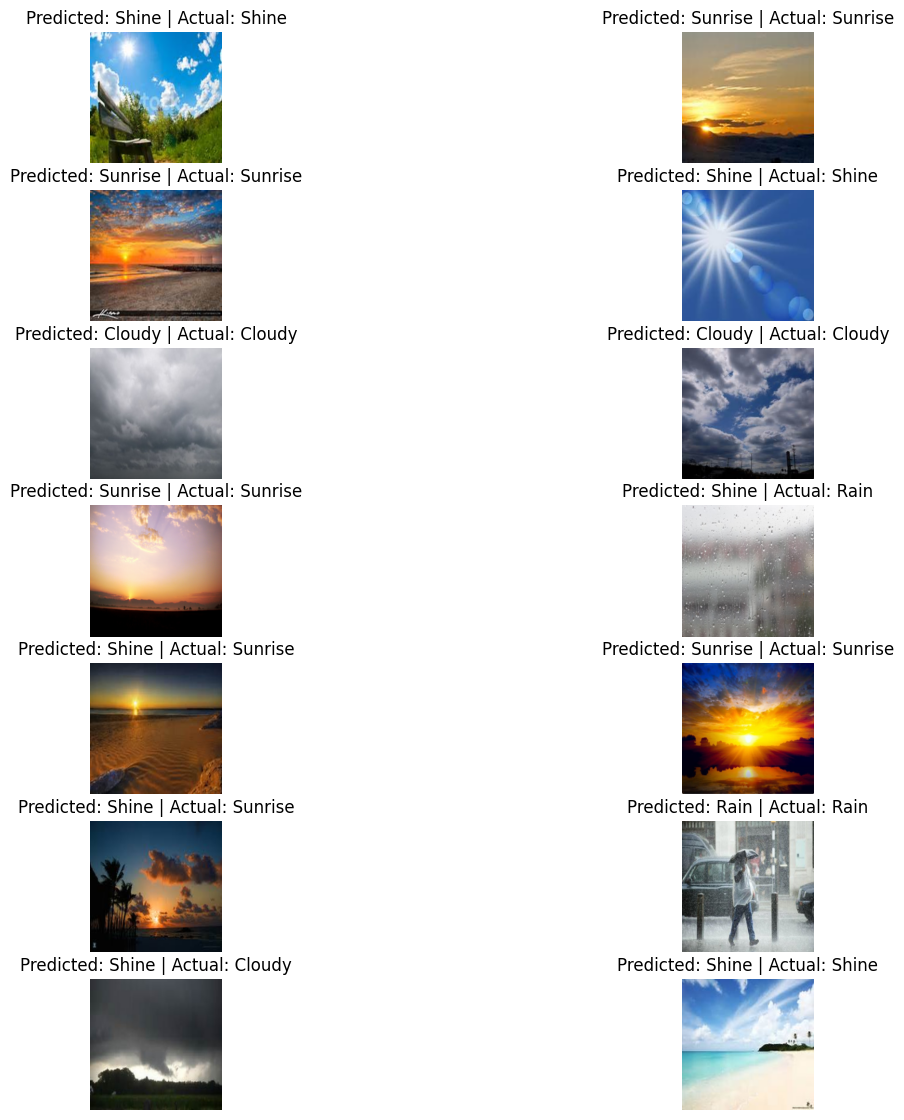

In [17]:
def imshow(img):
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))
    
visualize_model(model_ft, num_images=14)

## 7. Show predictions graphs and confusion matrix
- [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix): In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one.

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    size = len(classes)*2
    plt.figure(figsize = (size,size))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)

def model_verification(loader,batch_size,model,n_classes=5):
    classes = list(le.inverse_transform([i for i in range(n_classes)]))
    prediction_list,label_list = [],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1).detach()
            prediction_list.extend(predicted.tolist())
            label_list.extend(labels.tolist())
            
    cm = confusion_matrix(prediction_list,label_list)
    plot_confusion_matrix(cm, classes)
    if device.type == 'cuda':
        inputs = inputs.cpu()
        labels = labels.cpu()
    gc.collect()

Confusion matrix, without normalization
[[23  1  0  0]
 [ 0 17  0  0]
 [ 6  4 25 13]
 [ 1  0  0 22]]


AttributeError: 'str' object has no attribute 'type'

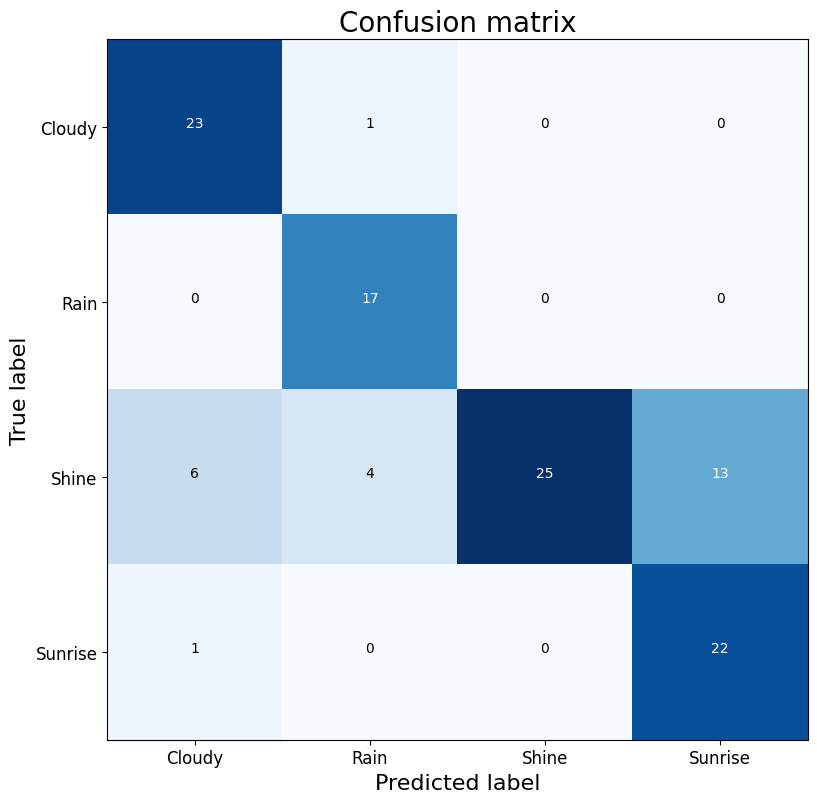

In [19]:
model_verification(dataloaders['val'],batch_size['val'],model_ft,n_classes=4)